In [17]:
import fastf1
import numpy as np
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import sklearn 
import time 

In [ ]:
df = pd.read_csv("data/f1_combined_data.csv")

In [58]:
df.head()

,Driver,LapTime_FP1,Compound_FP1,SpeedST_FP1,SpeedFL_FP1,SpeedI1_FP1,SpeedI2_FP1,LongestStintCompound_FP1,LongestStintLaps_FP1,AvgLapTime_LongestStint_FP1,...,Q3_Humidity,Q3_Pressure,TotalRaceTime,RacePosition,TeamName,SafetyCars,VirtualSafetyCars,FastestPracticeTime,FastestQualifyingTime,FastestPracticeCompound
0,ALB,89.392,SOFT,7.0,274.0,278.0,307.0,1.0,7.0,94.412250,...,60.0,1013.2,4967.350,9.0,Williams,0.0,0.0,88.554,87.615,0
1,ALO,89.222,SOFT,4.0,271.0,275.0,304.0,2.0,7.0,91.104000,...,NaN,NaN,4984.316,11.0,Aston Martin,0.0,0.0,89.222,87.897,0
2,ANT,89.284,SOFT,5.0,271.0,280.0,307.0,1.0,13.0,94.429889,...,60.0,1013.3,4945.654,6.0,Mercedes,0.0,0.0,89.126,87.555,0
3,BEA,90.077,SOFT,3.0,267.0,278.0,301.0,1.0,9.0,92.337500,...,60.0,1013.3,4981.512,10.0,Haas F1 Team,0.0,0.0,89.654,87.711,1
4,BOR,90.147,SOFT,2.0,268.0,277.0,305.0,2.0,13.0,94.285300,...,NaN,NaN,5010.880,19.0,Kick Sauber,0.0,0.0,89.335,88.622,0


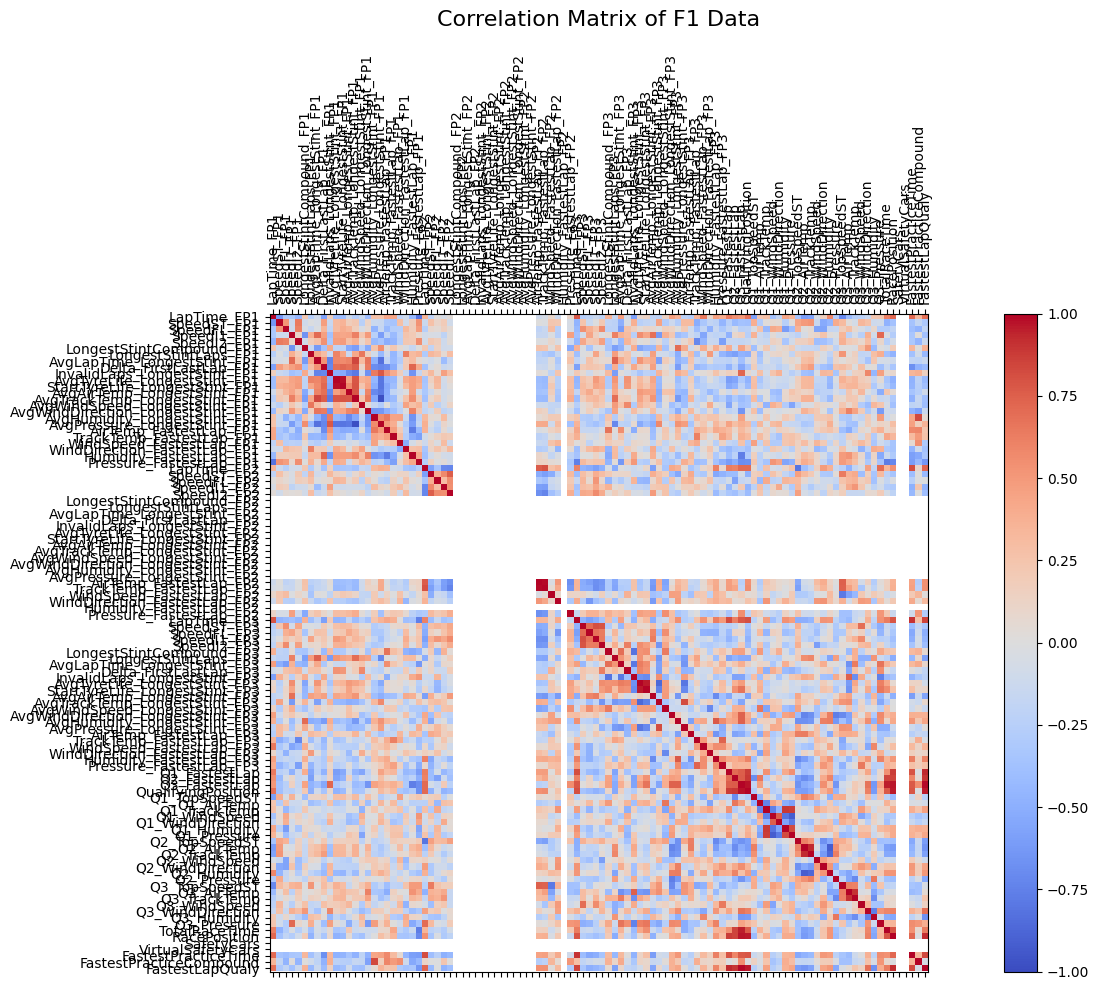

In [29]:
numeric_df = df.select_dtypes(include=['number'])
corr = numeric_df.corr()
fig, ax = plt.subplots(figsize=(16, 10))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
corr['RacePosition'].sort_values(ascending=True)
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)
plt.title("Correlation Matrix of F1 Data", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

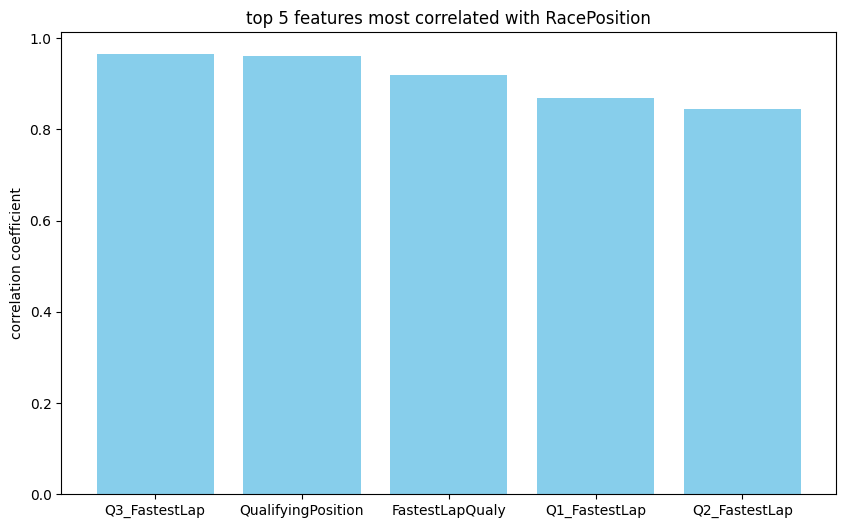

In [30]:
# most correlated features with RacePosition
corr_race = corr["RacePosition"]
corr_race = corr_race.drop("RacePosition")
sorted_corr = corr_race.abs().sort_values(ascending=False)
top5_features = sorted_corr.head(5).index
plt.figure(figsize=(10, 6))
plt.bar(top5_features, corr_race[top5_features], color='skyblue')
plt.ylabel("correlation coefficient")
plt.title("top 5 features most correlated with RacePosition")
plt.show()


In [31]:
# tried keeping only the stronger correlation values 
# there are so many values in the original matrix that it gets confusing
corr = df.corr(numeric_only=True)
threshold = 0.5
filtered_corr = corr.where(corr.abs() > threshold)
print(filtered_corr)


                         LapTime_FP1  SpeedST_FP1  SpeedFL_FP1  SpeedI1_FP1  \
LapTime_FP1                 1.000000    -0.625831          NaN          NaN   
SpeedST_FP1                -0.625831     1.000000     0.518997          NaN   
SpeedFL_FP1                      NaN     0.518997     1.000000          NaN   
SpeedI1_FP1                      NaN          NaN          NaN          1.0   
SpeedI2_FP1                      NaN     0.640362     0.603687          NaN   
...                              ...          ...          ...          ...   
SafetyCars                       NaN          NaN          NaN          NaN   
VirtualSafetyCars                NaN          NaN          NaN          NaN   
FastestPracticeTime         0.706366          NaN          NaN          NaN   
FastestPracticeCompound          NaN          NaN          NaN          NaN   
FastestLapQualy             0.686800          NaN          NaN          NaN   

                         SpeedI2_FP1  LongestStintC

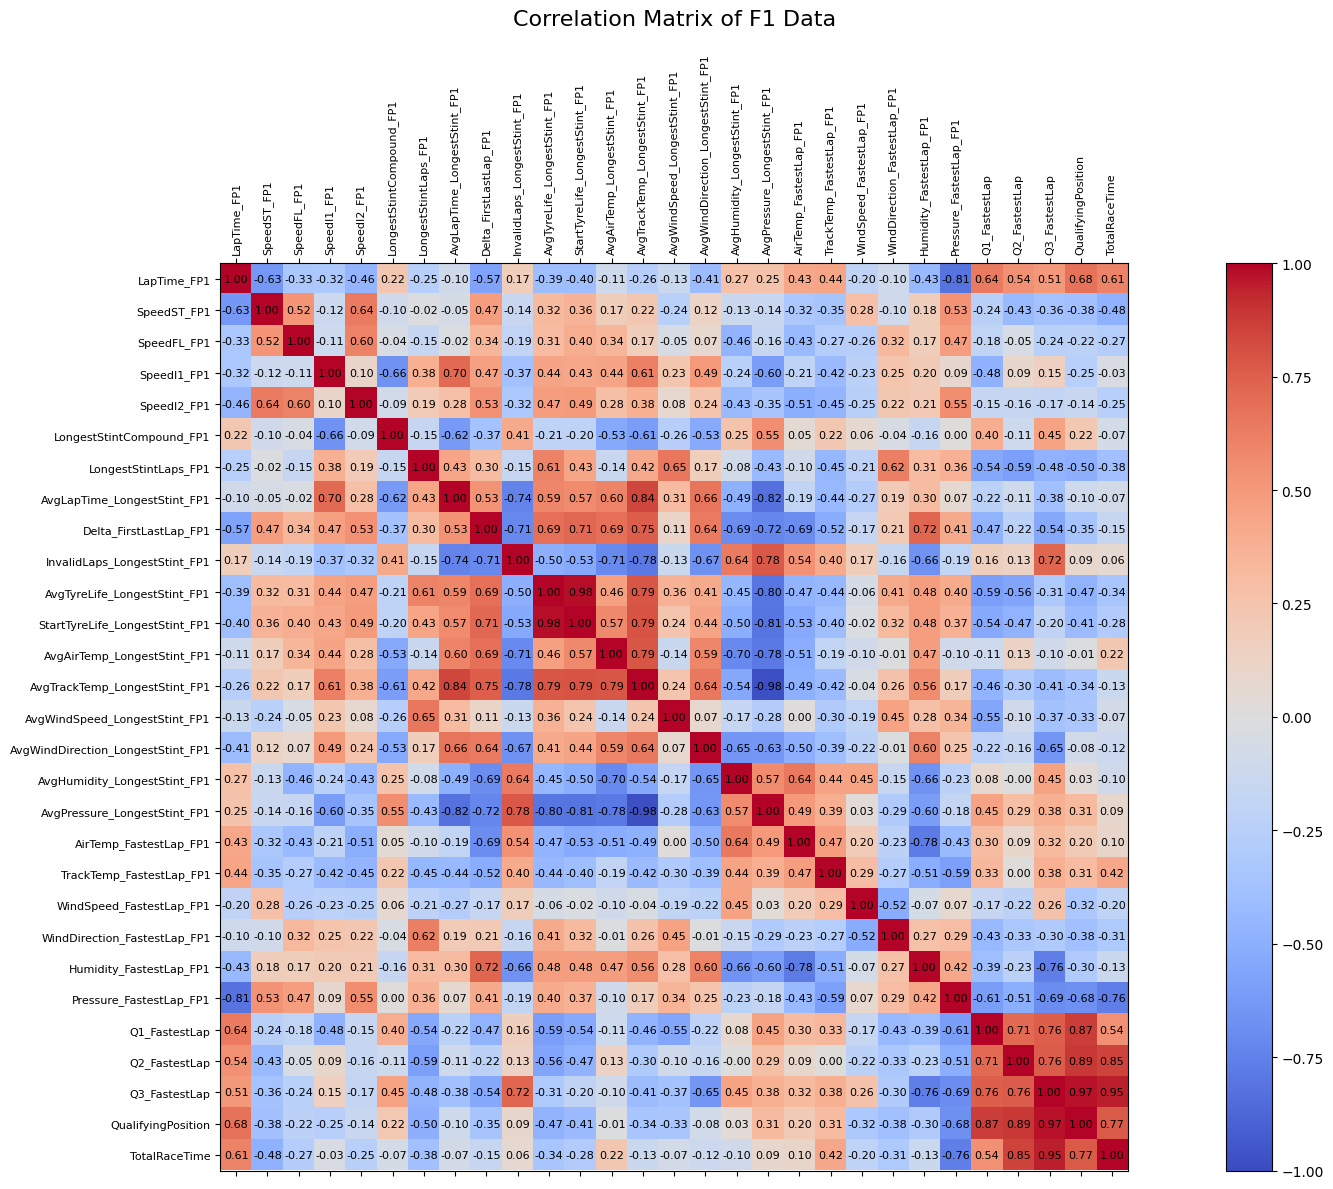

In [32]:
fp1_cols = df.columns[df.columns.str.contains('FP1')].tolist()
q_cols = df.columns[df.columns.str.contains('Q')].tolist()
q_cols_subset = q_cols[:4]
selected_cols = fp1_cols + q_cols_subset
filtered_df = df[selected_cols]
numeric_filtered_df = filtered_df.select_dtypes(include=['number'])
df["TotalRaceTime"] = pd.to_timedelta(df["TotalRaceTime"]).dt.total_seconds()
numeric_filtered_df["TotalRaceTime"] = df["TotalRaceTime"]


corr = numeric_filtered_df.corr()
fig, ax = plt.subplots(figsize=(20, 12))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90, fontsize = 8)
ax.set_yticklabels(corr.columns, fontsize = 8)
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        value = corr.iloc[i, j]
        ax.text(j, i, f"{value:.2f}", va='center', ha='center', color='black', fontsize=8)
plt.title("Correlation Matrix of F1 Data", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [33]:
corr_race = corr["RacePosition"]  
corr_race = corr_race.drop("RacePosition")  

sorted_corr = corr_race.abs().sort_values(ascending=False)
top5_features = sorted_corr.head(5).index 

plt.figure(figsize=(10, 6))
plt.bar(top5_features, corr_race[top5_features], color='skyblue')
plt.ylabel("Correlation Coefficient")
plt.title("Top 5 Features Most Correlated with RacePosition")
plt.show()

KeyError: 'RacePosition'